<a href="https://colab.research.google.com/github/Nohalyan/Projetppchem/blob/Lucas1/Notebook_WSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Water Solubility Predisction



## 1.1 Import Relevant Modules and Libraries

Let's first start by importing relevant modules and libraries needed for this project.


In [59]:
# Install all libraries
!pip install pathlib numpy pandas rdkit matplotlib scikit-learn lightgbm lazypredict tqdm

In [58]:
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

from lightgbm import LGBMRegressor

# lazypredict helps to train 42 ML models with a single line of code ans find the best ML models
import lazypredict
from lazypredict.Supervised import LazyRegressor

from tqdm import tqdm

import pickle


# 2.1 Let's get the Solubility Data

First, we will get solubility data from gashawmg (source: https://github.com/gashawmg) and perform exploratory data analysis

In [4]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data_Solubility.csv

--2024-04-23 07:59:54--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data_Solubility.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987356 (964K) [text/plain]
Saving to: ‘Data_Solubility.csv’

Data_Solubility.csv 100%[===================>] 964.21K  5.44MB/s    in 0.2s    

2024-04-23 07:59:55 (5.44 MB/s) - ‘Data_Solubility.csv’ saved [987356/987356]



Let's open the file

In [5]:
# Create a Path object for the current directory, in our case /content/
current_directory = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path = current_directory / "Data_Solubility.csv"

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
#       print(content)
else:
    print("The file does not exist.")


Current Directory: /content


The file use semicicolon as delimiter, so let's open the file and use semicicolon as delimiter:

In [6]:
# open a file containing descriptors and yield
data_solubility = pd.read_csv("/content/Data_Solubility.csv", delimiter=';')

Check the data see if it is what we want

In [7]:
data_solubility.shape

(9943, 6)

In [8]:
data_solubility.head()

,Compound ID,InChIKey,SMILES,logS,logP,MW
0,C1711,ACTIUHUUMQJHFO-UPTCCGCDSA-N,COC1=C(OC)C(=O)C(=C(C1=O)C/C=C(/CC/C=C(/CC/C=C...,-18.22,17.85,863.34
1,C1712,CQISYTXUORWJSX-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCC(=O)Nc1ccc(cc1)NC(=O)CCCCCCC...,-17.47,14.23,641.07
2,C1713,UXPYIAWFQKSHNV-UHFFFAOYSA-N,CCCCCCCCCCCCCCCC(=O)OCCCCOC(=O)CCCCCCCCCCCCCCC,-16.26,11.82,566.94
3,C1714,BDIWFCKBPZPBQT-UHFFFAOYSA-N,CCCC[Sn](S[Sn](CCCC)(CCCC)CCCC)(CCCC)CCCC,-15.68,10.41,612.15
4,C1715,RNPXCFINMKSQPQ-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCOP(=O)(OCCCCCCCCCCCCCCCC)O,-15.21,12.08,546.85


Looks nice to me!

#2.2 Data Cleaning
## 2.2.1 Remove NaN or null values

We wil start by removing non-numerical values and valeurs that are null:

In [9]:
data_solubility.SMILES.isnull().sum()
data_solubility.dropna(inplace=True)
data_solubility.shape

(9943, 6)

As we can see, the shape is still the same, the data has already been cleaned of non-numerical and null values.
##2.2.2 Remove outliers

Then, we will remove outliers from the data. Using a boxplot, we can easely visualize outliers:


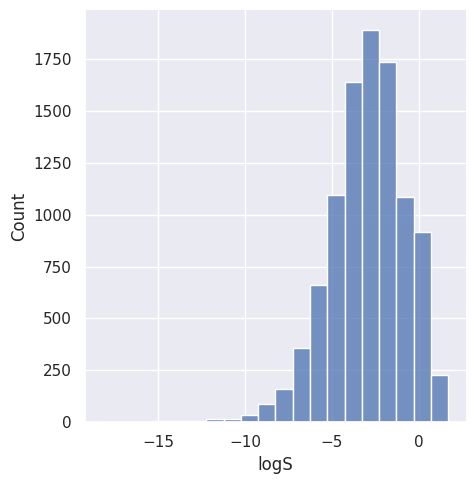

In [10]:
sn.set_theme()
sn.displot(data=data_solubility, x="logS", binwidth=1)

Let's filter compounds that follow as close as normal distribution, let's say between -7.5 and 1.7:


In [11]:
new_data_solubility = data_solubility[data_solubility.logS.apply(lambda x: x > -7.5 and x < 1.7)]

Let's generate an histogram to see the new data:

(9648, 6)

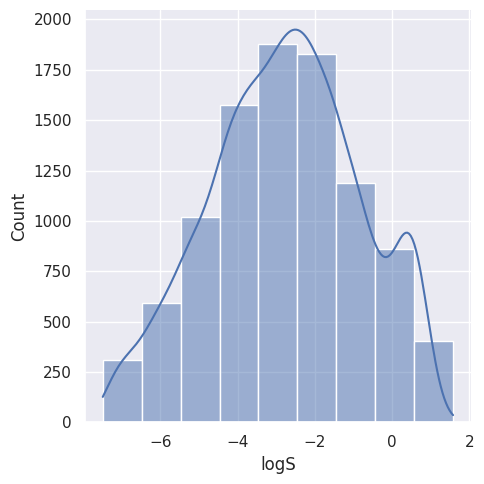

In [12]:
sn.displot(data=new_data_solubility, x='logS', binwidth=1,kde=True)
new_data_solubility.shape

##2.2.3 Remove Duplicates

Then remove duplicate by generating canonical SMILES:

In [13]:
# generate a canonical SMILES function
def canonical_SMILES(smiles):
    canon_smls = [Chem.CanonSmiles(smls) for smls in smiles]
    return canon_smls

In [14]:
# Generate canonical Smiles using the function
canon_smiles = canonical_SMILES(new_data_solubility.SMILES)

# Replace SMILES column with canonical SMILES
new_data_solubility["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_smiles = new_data_solubility[new_data_solubility['SMILES'].duplicated()]['SMILES'].values
len(duplicate_smiles)

6

As we can see, their are 6 duplicates, so we have to filter them and we can also sort them for better reading:

In [15]:
new_data_solubility[new_data_solubility['SMILES'].isin(duplicate_smiles)].sort_values(by=['SMILES'])

,Compound ID,InChIKey,SMILES,logS,logP,MW
5683,C1698,WUBBRNOQWQTFEX-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44,1.00,222.25
5836,C943,BZKPWHYZMXOIDC-UHFFFAOYSA-N,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.36,1.00,222.25
7282,C7745,VWPOSFSPZNDTMJ-UCWKZMIHSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.57,1.03,309.40
8063,C1707,IWVCMVBTMGNXQD-PXOLEDIWSA-N,CC(C)(C)NCC(O)COc1cccc2c1C[C@H](O)[C@H](O)C2,-1.01,1.03,309.40
1345,C199,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
1347,C1673,WKRLQDKEXYKHJB-HFTRVMKXSA-N,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc43)[C@@H]1CCC2=O,-5.28,3.74,268.35
5152,C1696,QZUDBNBUXVUHMW-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.70,3.10,253.28
5319,C843,JLKIGFTWXXRPMT-UHFFFAOYSA-N,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,-2.62,3.10,253.28
3918,C604,NXFQHRVNIOXGAQ-YCRREMRBSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.38,0.86,238.16
4159,C1690,NXFQHRVNIOXGAQ-OQFOIZHKSA-N,O=C1CN(/N=C/c2ccc([N+](=O)[O-])o2)C(=O)N1,-3.24,0.86,238.16


Let's drop rows that contain duplicate SMILES and keep the first structure:

In [16]:
data_solubility_cleaned = new_data_solubility.drop_duplicates(subset=['SMILES'], keep='first')
data_solubility_cleaned.shape
data_solubility_cleaned.head()

,Compound ID,InChIKey,SMILES,logS,logP,MW
294,C1951,NZFNXWQNBYZDAQ-UHFFFAOYSA-N,CSc1ccc2c(c1)N(CCC1CCCCN1C)c1ccccc1S2.Cl,-7.49,6.69,407.04
295,C1952,CIMQMKORBAJNEC-UHFFFAOYSA-N,CC(=O)OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc...,-7.49,6.42,552.48
296,C1953,MOPIFNSMNXBREW-UHFFFAOYSA-N,CCCCCCCNc1c2ccccc2nc2ccccc12,-7.48,5.84,292.42
297,C1954,CKHJPWQVLKHBIH-ZDSKVHJSSA-N,C/C(=C(\CCOC(=O)C(C)C)SS/C(CCOC(=O)C(C)C)=C(/C...,-7.47,7.12,702.89
298,C1955,NAPSCFZYZVSQHF-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCN(C)C,-7.46,6.81,297.56


## 2.2.4 Filter training data

Now that we have a dataset, let's prepapare a test stet containing 100 drug-like compounds (source: https://github.com/PatWalters/solubility)

In [17]:
!wget https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data_Drug_Like_Solubility.csv

--2024-04-23 08:00:00--  https://raw.githubusercontent.com/Nohalyan/Projetppchem/main/Data_Drug_Like_Solubility.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5557 (5.4K) [text/plain]
Saving to: ‘Data_Drug_Like_Solubility.csv’

Data_Drug_Like_Solu 100%[===================>]   5.43K  --.-KB/s    in 0s      

2024-04-23 08:00:01 (34.0 MB/s) - ‘Data_Drug_Like_Solubility.csv’ saved [5557/5557]



In [18]:
# Create a Path object for the current directory, in our case /content/
current_directory_dl = Path.cwd()
print("Current Directory:", current_directory.resolve())

file_path_dl = current_directory / "Data_Drug_Like_Solubility.csv"

# Reading the contents of the file and check that the file exists
if file_path.exists():
    with file_path.open("r") as file:
        content = file.read()
#        print(content)
else:
    print("The file does not exist.")


Current Directory: /content


In [19]:
data_dl = pd.read_csv("/content/Data_Drug_Like_Solubility.csv", delimiter=';')
data_dl.shape

(100, 3)

In [20]:
data_dl.head()

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,O=C(Nc1ccccc1)C,-1.40
1,Adenosine,c1nc(c2c(n1)n(cn2)[C@H]3[C@@H]([C@@H]([C@H](O3...,-1.73
2,Allopurinol,c1c2c([nH]n1)ncnc2O,-2.26
3,Trimethoprim,COc1cc(cc(c1OC)OC)Cc2cnc(nc2N)N,-2.95
4,Acetazolamide,O=S(=O)(c1nnc(s1)NC(=O)C)N,-2.44


In [23]:
# Generate canonical Smiles
canon_smiles = canonical_SMILES(data_dl.SMILES)

# Replace SMILES column wit Canonical SMILES
data_dl["SMILES"] = canon_smiles

# Create a list for duplicate smiles
duplicate_data_dl_smiles = data_dl[data_dl['SMILES'].duplicated()]['SMILES'].values
len(duplicate_data_dl_smiles)

0

In [26]:
# Molecules used in training and test of the model
data_dl_SMILES = data_dl.SMILES.values

# Filter molecules that are not present in the test set
data_cleaned_final = data_solubility_cleaned[~data_solubility_cleaned['SMILES'].isin(data_dl_SMILES)]
print(f'Compounds present in training set:{len(data_solubility_cleaned) - len(data_cleaned_final)}')
data_cleaned_final.shape

Compounds present in training set:93


(9549, 6)

In [29]:
data_dl= data_dl[data_dl['LogS exp (mol/L)'].apply(lambda x: x > -7.5 and x < 1.7)]
data_dl

,Chemical name,SMILES,LogS exp (mol/L)
0,Acetanilide,CC(=O)Nc1ccccc1,-1.40
1,Adenosine,Nc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@H]1O,-1.73
2,Allopurinol,Oc1ncnc2[nH]ncc12,-2.26
3,Trimethoprim,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,-2.95
4,Acetazolamide,CC(=O)Nc1nnc(S(N)(=O)=O)s1,-2.44
...,...,...,...
95,Sulfanilamide,Nc1ccc(S(N)(=O)=O)cc1,-1.36
96,Gliclazide,Cc1ccc(S(=O)(=O)NC(=O)NN2CC3CCCC3C2)cc1,-4.29
97,Trihexyphenidyl,OC(CCN1CCCCC1)(c1ccccc1)C1CCCCC1,-5.20
98,Triphenylene,c1ccc2c(c1)c1ccccc1c1ccccc21,-6.73


# 3. Calculation of RDkit Molecular Descriptors, which are molecular features

In [30]:
def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0]
                                    for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    Mol_descriptors =[]
    for mol in tqdm(mols):
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(data_cleaned_final['SMILES'])

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[08:17:20] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[08:17:20] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[08:17:20] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/

In [31]:
df_descriptors = pd.DataFrame(Mol_descriptors, columns=desc_names)
df_descriptors.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.25,9.25,0.05,-4.68,0.55,46.96,407.05,379.83,406.13,140,...,1,0,0,0,0,0,0,0,0,0
1,14.36,14.36,0.00,-5.72,0.41,36.20,552.49,522.25,551.14,194,...,0,0,0,0,0,0,0,0,0,0
2,8.72,8.72,0.55,-4.55,0.44,31.45,292.43,268.23,292.19,114,...,0,0,0,0,0,0,0,0,0,0
3,13.83,13.83,0.86,-5.29,0.12,30.50,702.90,656.54,702.30,262,...,0,0,0,0,0,0,0,0,0,0
4,8.30,8.30,1.26,-5.38,0.27,55.19,297.57,254.23,297.34,128,...,0,0,0,0,0,0,0,0,0,0


In [32]:
df_descriptors.shape

(9549, 210)

# 4. Split the chemicals for training and validation set

In [33]:
x_train, x_valid, y_train, y_valid = train_test_split(df_descriptors, data_cleaned_final.logS, test_size=0.1,random_state=42)

#Standardization of the features

custom_scaler = StandardScaler()
custom_scaler.fit(x_train)
x_train_scaled = custom_scaler.transform(x_train)
x_valid_scaled = custom_scaler.transform(x_valid)

#5. Select Machine Learning Models

Let's selct the best ML models for that. To do that, we will use the lazypredict librarie, in particular the LazyRegressor function to test 42 ML models:

In [34]:
lregs = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,random_state=42)
models, prediction_tests = lregs.fit(x_train_scaled, x_valid_scaled, y_train, y_valid)

 98%|█████████▊| 41/42 [05:44<00:04,  4.52s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20819
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 188
[LightGBM] [Info] Start training from score -2.762630


100%|██████████| 42/42 [05:46<00:00,  8.25s/it]


In [40]:
#The top three models
prediction_tests[:5]

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.82,0.86,0.74,15.19
LGBMRegressor,0.81,0.85,0.75,2.12
ExtraTreesRegressor,0.80,0.84,0.77,28.04
XGBRegressor,0.79,0.84,0.78,3.73
RandomForestRegressor,0.79,0.84,0.78,65.07


#6. Fine-tuning of LGBMRegressor

We decided to take the LGBMRegressor model because the results generated by this model are comparable to the ExtraTreesRegressor model, but takes a lot less time than the extra-trees model.Let's performs a grid search using GridSearchCV from scikit-learn to find the best hyperparameters for a LightGBM regressor:

In [36]:
params = {'max_depth' : list(range(2, 32, 8)),
          'n_estimators' : list(range(1, 1000, 100)),
          'learning_rate' : list(np.arange(0.01, 1.02, 0.25))}

grid_search = GridSearchCV(LGBMRegressor(random_state = 42),
                            param_grid=params, cv=5, verbose=1)

grid_search.fit(x_train, y_train)

print("Optimized parameters for a LightGBM regressor can be: ", grid_search.best_params_)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

We obtained:
* learning_rate: 0.01
* max_depth: 26
* n_estmitors: 901

Let's optimize again with new ranges for liste max_depth, n_estmitors and learning_rate to obtain even better parameters:


In [43]:
params_bst = {"max_depth" : list(range(20, 36, 4)),
         "n_estimators" : list(range(850, 1200, 50)),
         "learning_rate" : list(np.arange(0.01, 0.05, 0.01))}

grid_search_bst = GridSearchCV(LGBMRegressor(random_state = 42),
                                  param_grid=params_bst, cv=3, verbose=1)

grid_search_bst.fit(x_train, y_train)
print("The best parameters are: ", grid_search_bst.best_params_)

Fitting 3 folds for each of 112 candidates, totalling 336 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20548
[LightGBM] [Info] Number of data points in the train set: 5729, number of used features: 187
[LightGBM] [Info] Start training from score -2.739573
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set 

#7. LGBMRegressor model for training and test data
Let's test our model ont the training and test set with the best parameters found with the fine tunning:
* learning_rate: 0.04
* max_depth: 24
* n_estmitors: 1150




In [44]:
model = LGBMRegressor(n_estimators = 1150,
                      max_depth = 24,
                      learning_rate = 0.04,
                      random_state= 42)

model.fit(x_train_scaled,y_train)
y_preds = model.predict(x_valid_scaled)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20899
[LightGBM] [Info] Number of data points in the train set: 8594, number of used features: 195
[LightGBM] [Info] Start training from score -2.762630
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [52]:
# A plotting function
def plot_data(actual, predicted, title):

# model performance using RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted))

# R^2 (coefficient of determination) :
    R2 =r2_score(actual, predicted)
    plt.figure(figsize=(8,6))

# Plot the figure
    sn.regplot(x=predicted , y=actual,line_kws={"lw":2,
                                                "ls":"--",
                                                "color":"red",
                                                "alpha":0.7})
    plt.title(title, color="red")
    plt.xlabel("Predicted logS(mol/L)",
               color="blue")
    plt.xlim(-8,1)
    plt.ylabel("Experimental logS(mol/L)",
               color ="blue")


    plt.grid(alpha=0.3)
    R2 = mpatches.Patch(label="R2={:04.2f}".format(R2))
    rmse = mpatches.Patch(label="RMSE={:04.2f}".format(rmse))
    plt.legend(handles=[R2, rmse])

Let's plot the predicted logS of the validation set and see if our model works:

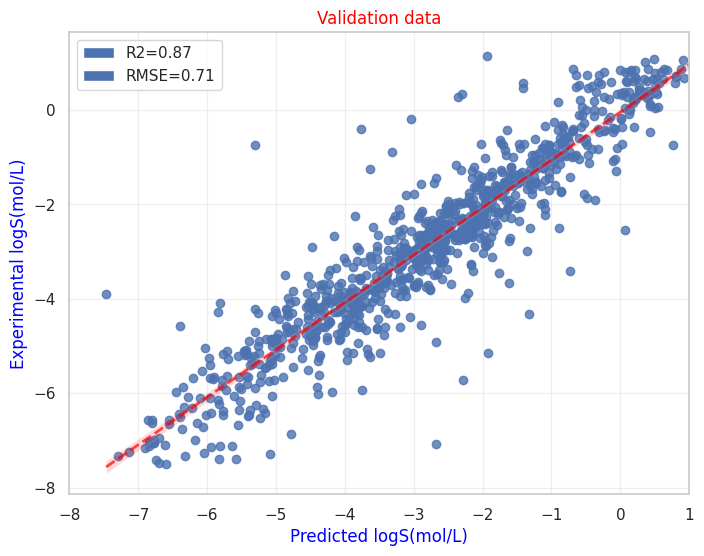

In [53]:
sn.set_theme(style="whitegrid")
plot_data(y_valid,y_preds,"Validation data")

In [54]:
#Calculate molecular descriptors for the test data or 98 compounds

Mol_descriptors_test , desc_names_test = RDkit_descriptors(data_dl["SMILES"])
data_dl_descriptors = pd.DataFrame(Mol_descriptors_test,columns=desc_names_test)

# Standard scaler - transform
x_scaled_test = custom_scaler.transform(data_dl_descriptors)

# Predict solubility of the test data
y_test_preds = model.predict(x_scaled_test)



Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[13:24:21] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[13:24:21] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/build/temp.linux-x86_64-cpython-310/rdkit/Code/GraphMol/Descriptors/Crippen.cpp
Failed Expression: logpContribs.size() == mol.getNumAtoms() && mrContribs.size() == mol.getNumAtoms()
----------
Stacktrace:
----------
****

[13:24:21] 

****
Pre-condition Violation
bad result vector size
Violation occurred on line 40 in file /project/

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


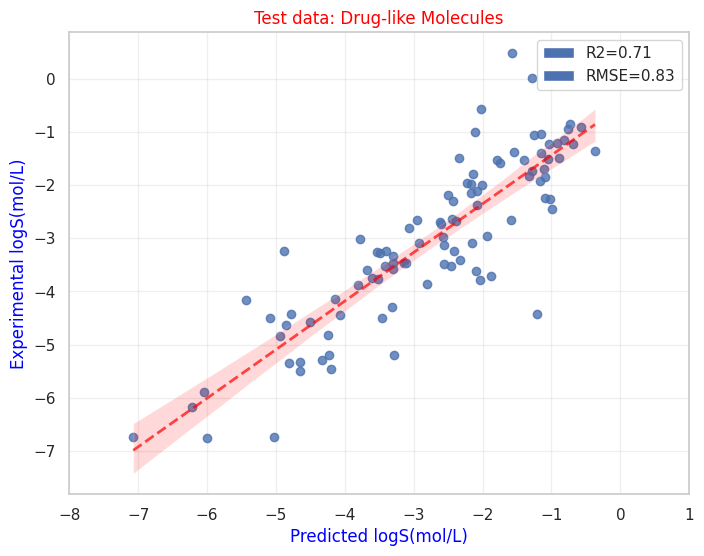

In [55]:
# Plotting testing set
sn.set_theme(style="whitegrid")
plot_data(data_dl["LogS exp (mol/L)"], y_test_preds,
           "Test data: Drug-like Molecules")

#8. Saving of the trained model and standard scaler

In [62]:
with open("model_WSP.pkl","wb") as f:
    pickle.dump(model,f)

with open("scaler_WSP.pkl","wb") as f:
    pickle.dump(custom_scaler,f)

In [63]:
%ls

Data_Drug_Like_Solubility.csv  model.pkl      sample_data/  scaler_WSP.pkl
Data_Solubility.csv            model_WSP.pkl  scaler.pkl
